# Projet TER

In [1]:
from __future__ import print_function
# %matplotlib inline
import argparse
import os
import os.path as osp
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm
from torch import Tensor
import pickle
from datetime import datetime

import copy # To make a copy of a model


from torchvision import datasets, transforms
from torch.utils.data import random_split

from torchsummary import summary


import utils
from utils.dataset import SegmentationDataSet
from utils.printer import source_printer
from utils.printer import target_printer
from utils.model import GenericNetwork
from utils.model import TeacherNetwork
from utils.model import StudentNetworkSmall
from utils.model import UNet_modular
from utils.model import UNet
from utils.model import YNet
from utils.model import Recons_net
from utils.model import ClassifNet
from utils.utils import getLossAccuracyOnDataset
from utils.utils import preprocessing
from utils.utils import IoU
from utils.utils import postprocessing
from utils.utils import dice_coeff
from utils.utils import multiclass_dice_coeff
from utils.utils import dice_loss
from utils.utils import smooth


# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


/home/mehtali/env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
def load_model(model, path=""):
    if len(path)>0:
        state_dict = torch.load(path)
        model.load_state_dict(state_dict)
    model.to(device=device)

    if (device.type == 'cuda') and (ngpu > 1):
        print("Data Parallel")
        model = nn.DataParallel(model, list(range(ngpu)))
    
    return model


def load_student_model(path=""):
    # STUDENT
    return load_model(UNet_modular(channel_depth = 16, n_channels = 3, n_classes=3), path)


def load_teacher_model(path=""):
    # TEACHER
    return load_model(UNet_modular(channel_depth = 32, n_channels = 3, n_classes=3), path)

# Other

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Function that returns a list of paths in a folder that start with a word
def get_path_list(path, start_with=""):
    path_list = [osp.join(path, f) for f in os.listdir(path) if f.startswith(start_with)]
    return path_list

# Function that returns the names in a path list with the last number in the name
def get_last_number_in_name(path_list):
    last_number = [int(f.split("_")[-1].split(".")[0]) for f in path_list]
    return last_number

def get_trainable_param(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])


def show_prediction(model, val_loader, n=0):
    model.eval().cuda()

    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for i,(img,gt) in enumerate(val_loader):
            if n !=0 and i > n:
                break
        
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = model(img)
            output = output.clamp(min = 0, max = 1)
            gt = gt.clamp(min = 0, max = 1)

            # Plot image, output and ground truth one one row
            fig, ax = plt.subplots(1,3, figsize=(15,15))
            ax[0].set_title("Input")
            ax[0].imshow(img[0].cpu().numpy().transpose(1,2,0))
            ax[1].set_title("Output")
            ax[1].imshow(output[0].cpu().numpy().transpose(1,2,0))
            ax[2].set_title("Ground Truth")
            ax[2].imshow(gt[0].cpu().numpy().transpose(1,2,0))
            plt.show()
    

In [3]:
date = str(datetime.now()).split(' ')[0]
heure = str(datetime.now()).split(' ')[1].split('.')[0]

# Root directory for dataset
# Refaire nos data folder et tout pour que ce soit
# au format demandé par le dataloader

# Leave empty if you want to use the default name or load a previous session
session_name = "IGBMC_I3_FINAL"

if len(session_name) == 0:
    session_name = "IGBMC_I3"+"_"+str(date)+"_"+str(heure)
    

dataset_folder = "/home/mehtali/TER_CNN_Compression/Data/training-data/data/IGBMC_I3_diversifie/patches/"
train_list = dataset_folder+"train_2500_i3.txt"
test_list = dataset_folder+"test_5000-7500_i3.txt"
validate_list = dataset_folder+"test_1000.txt"


# Number of workers for dataloader
workers = 10

# Batch size during training (low batch_size if there are memory issues)
batch_size = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size_source = 256
image_size_target = 256
image_size_discriminator = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
learning_rate = 1e-5  # e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Saves every batch_save_interval
batch_save_interval = 2

# some net variable
amp = False

save_path =  "../Data/Saves/" + session_name
model_save_path = save_path+"/newtork_weigths/"

if not os.path.exists("../Data"):
    os.mkdir("../Data")
if not os.path.exists("../Data/Saves" ):
    os.mkdir("../Data/Saves" )

# We create this folder (only if it doesn't exists) to save weights of the training at some keys epoch
if not os.path.exists(save_path):
    os.mkdir(save_path)
    os.mkdir(save_path+"/loss-dice_listes")
    os.mkdir(save_path+"/newtork_weigths")
    os.mkdir(save_path+"/training_monitoring")

log_file = open(save_path+"/log+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("dataset_folder :"+dataset_folder+"\n")
log_file.write("batch_size="+str(batch_size)+"\n")
log_file.write("learning_rate_net="+str(learning_rate)+"\n")
log_file.write("num_epoch="+str(num_epochs)+"\n")
log_file.write("nc="+str(nc)+"\n")
log_file.close()


In [4]:
print("number of gpus :", torch.cuda.device_count())

# Decide which device we want to run on
device = torch.device("cuda:0" if (
    torch.cuda.is_available() and ngpu > 0) else "cpu")

# On regarde l'identifiant du GPU ou CPU sur lequel on travaille
print("device ID", device)
print("nom du GPU", torch.cuda.get_device_name(device))  # On vérifie son "nom"

torch.cuda.empty_cache()


number of gpus : 4
device ID cuda:0
nom du GPU NVIDIA GeForce RTX 2080 Ti


images source :  torch.Size([10, 3, 256, 256])
mask source : torch.Size([10, 1, 256, 256])


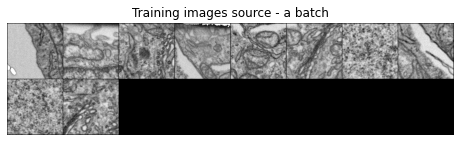

In [5]:
# For data augmentation

geometric_augs = [
    # transforms.Resize((256, 256)), # Makes it easier to process using net
    #transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(45),
]

color_augs = [
    transforms.ColorJitter(hue=0.05, saturation=0.4)
]


def make_tfs(augs):
    return transforms.Compose([transforms.ToPILImage()]+augs + [transforms.ToTensor()])


tfs = transforms.Compose(geometric_augs)


# Importation des images et masques de i3
train_dataset = SegmentationDataSet(root=dataset_folder,
                              list_path=train_list,
                              #transform_img=make_tfs(
                              #    geometric_augs + color_augs),
                              #  transform_label=make_tfs(geometric_augs)
                              )

# Not a good idea to augment the test data
test_dataset = SegmentationDataSet(root=dataset_folder,
                                list_path=test_list
                                )
# Not a good idea to augment the test data
validate_dataset = SegmentationDataSet(root=dataset_folder,
                                list_path=validate_list
                                )



train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=workers)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)

validation_dataloader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=workers)


batch = next(iter(train_dataloader))

# On affiche quelques exemple du batch pour vérifier qu'on a bien importé les données
print("images source : ", batch[0].shape)
print("mask source :", batch[1].shape)



plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images source - a batch")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(
    device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


# Neural net architecture

## Load or create neural net

In [6]:
# On revérifie qu'on tourne bien le réseau de neuronnes sur le GPU
print("We are running U-Net on :", torch.cuda.get_device_name(device))

print("Teacher network summary")
teacher_summary = summary(load_teacher_model(), (3, 256, 256), verbose=0)

print("Student network summary")
student_summary = summary(load_student_model(), (3, 256, 256), verbose=0)


log_file = open(save_path+"/model_architectures+"+"_"+date+"_"+heure+".txt", "w")

log_file.write("Teacher network summary\n"+str(teacher_summary)+"\n\n")
log_file.write("Student network summary\n"+str(student_summary)+"\n")
log_file.close()

We are running U-Net on : NVIDIA GeForce RTX 2080 Ti
Teacher network summary
Student network summary


## Training

In [7]:
def evaluate(model, val_loader):
    model.eval().cuda()

    criterion = nn.BCEWithLogitsLoss()
    ll = []
    dl = []
    with torch.no_grad():
        for i,(img,gt) in enumerate(val_loader):
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            img, gt = Variable(img), Variable(gt)

            output = model(img)
            output = output.clamp(min = 0, max = 1)
            gt = gt.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)
            dice = dice_coeff(output, gt)
            ll.append(loss.item())
            dl.append(dice.item())

    
    mean_dice = np.mean(dl)
    mean_loss = np.mean(ll)
    print("Eval metrics : dice {:.3f} and loss {:.3f}.".format(mean_dice, mean_loss))
    return mean_dice, mean_loss


def train(model, optimizer, train_loader):
    model.train().cuda()
    criterion = nn.BCEWithLogitsLoss()
    ll = []
    dl = []
    with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
        for i, (img, gt) in enumerate(train_loader):
            #print('i', i)
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            
            img, gt = Variable(img), Variable(gt)

            optimizer.zero_grad()
            output = model(img)
            output = output.clamp(min = 0, max = 1)
            gt = gt.clamp(min = 0, max = 1)
            loss = dice_loss(output, gt)
            dice = dice_coeff(output, gt)
            ll.append(loss.item())
            dl.append(dice.item())

            
            
            loss.backward()

            optimizer.step()

            pbar.update(len(img))
            pbar.set_postfix(**{'loss': loss.item(), "dice": dice.item()})
    
    mean_dice = np.mean(dl)
    mean_loss = np.mean(ll)

    print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

    return mean_dice, mean_loss


T = 1.0 # temperature for distillation loss
# Using a higher value for T produces a softer probability distribution over classes
alpha = 0.9
# trade-off between soft-target (st) cross-entropy and true-target (tt) cross-entropy;
# loss = alpha * st + (1 - alpha) * tt

def kd_loss(student_preds, teacher_preds, hard_labels, temperature, alpha):
    # Calculate the soft targets by applying softmax to the teacher predictions
    soft_targets = nn.functional.softmax(teacher_preds / temperature, dim=1)
    soft_pred = nn.functional.log_softmax(student_preds / temperature, dim=1)
    
    # Calculate the soft target loss using KL divergence
    kl_loss = nn.KLDivLoss(reduction='batchmean')(soft_pred, soft_targets) * (temperature ** 2)



    # Calculate the hard target loss using binary cross-entropy loss
    student_loss = dice_loss(student_preds.clamp(min = 0, max = 1), hard_labels)#nn.functional.binary_cross_entropy_with_logits(student_preds, hard_labels)
    
    # Combine the soft and hard losses
    loss = alpha * kl_loss + (1 - alpha) * student_loss

    #loss = nn.KLDivLoss()(F.log_softmax(student_preds/temperature, dim=1),
    #                         F.softmax(teacher_preds/temperature, dim=1)) * (alpha * temperature * temperature) + \
    #          dice_loss(student_preds.clamp(min = 0, max = 1), hard_labels) * (1. - alpha)
    return loss

def train_distilled(model, optimizer, train_loader):
    model.train().cuda()
    criterion = nn.BCEWithLogitsLoss()
    ll = []
    dl = []
    with tqdm(total=len(train_loader)*train_loader.batch_size, desc=f'Training', unit='img') as pbar:
        for i, (img, gt) in enumerate(train_loader):
            #print('i', i)
            if torch.cuda.is_available():
                img, gt = img.cuda(), gt.cuda()
            
            img, gt = Variable(img), Variable(gt)

            teacher_output = g_teacher_model(img).detach()

            if torch.cuda.is_available():
                teacher_output = teacher_output.cuda()
            
            teacher_output =  Variable(teacher_output)


            optimizer.zero_grad()
            student_output = model(img)
            
            gt = gt.clamp(min = 0, max = 1)
            #student_output = student_output.clamp(min = 0, max = 1)
            #teacher_output = teacher_output.clamp(min = 0, max = 1)

            #student_loss = dice_loss(student_output, gt)
            # Try pixel-wise loss later on
            #loss = dice_loss(student_output, teacher_output) #pixel_wise_loss(student_output, teacher_output)
            #kd_loss = F.kl_div(F.log_softmax(student_output / T, dim=1), F.softmax(teacher_output / T, dim=1), reduction='batchmean')
            #loss = kd_loss * alpha + student_loss * (1 - alpha)
            # How to factor T in ?
            loss = kd_loss(student_output, teacher_output, gt, T, alpha)
            
            

            # Still calculate dice on student output and gt
            dice = dice_coeff(student_output, gt)

            ll.append(loss.item())
            dl.append(dice.item())

            
            loss.backward()

            optimizer.step()

            pbar.update(len(img))
            pbar.set_postfix(**{'loss': loss.item(), "dice": dice.item()})
    
    mean_dice = np.mean(dl)
    mean_loss = np.mean(ll)

    print("Average dice {:.3f} and loss {:.3f} over this epoch.".format(mean_dice, mean_loss))

    return mean_dice, mean_loss

def model_training(model, train_loader, val_loader, trainFun, evalFun, n_epochs, name="model"):
    #model = copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size = 100, gamma = 0.2)

    former_best_dice = 0 # Worst possible
    former_best_loss = 1 # Worst possible
    early_stopping_streak = 0

    scheduled_saves = 0
    best_modem = model

    for epoch in range(n_epochs):
        print(' --- training: epoch {}'.format(epoch+1))

        # Train the model
        train_dice, train_loss = trainFun(model, optimizer, train_loader)

        # Modulate training rate
        scheduler.step()

        #evaluate for one epoch on validation set
        valid_dice, valid_loss = evalFun(model, val_loader)
        
        #if val_metric is best, add checkpoint
        if (epoch%5 == 0 or epoch==(n_epochs-1)):
            scheduled_saves+=1
        

        if former_best_dice < valid_dice:
            # dice is increasing
            early_stopping_streak = 0
            best_modem = copy.deepcopy(model)
            if scheduled_saves > 0:
                scheduled_saves -= 1
                save_model(model, model_save_path+name+"_dice_{:.3f}_loss_{:.3f}_epoch_{}.pth".format(valid_dice, valid_loss, epoch+1))
        else:
            # Is decresing
            early_stopping_streak += 1
            if early_stopping_streak >= 15:
                # 15 consecutive epochs without improvement in dice
                print("Early stopping at epoch {}".format(epoch+1))
                break
        
        former_best_dice = max(former_best_dice, valid_dice)
        former_best_loss = min(former_best_loss, valid_loss)
        
    return best_modem


In [8]:
n_epochs = 3
n_models = 10

In [9]:
global g_teacher_model
g_teacher_model = load_model(UNet_modular(channel_depth=32, n_channels=3, n_classes=1), model_save_path+"best_teacher_model_parameters_3352257")
#model_descr = "_model_parameters_{}".format(get_trainable_param(g_teacher_model))
#g_teacher_model = model_training(g_teacher_model, train_dataloader, validation_dataloader, train, evaluate, 50, "teacher"+model_descr)
#save_model(g_teacher_model, model_save_path+"best_teacher"+model_descr)

for i in range(1, n_models+1):
    
    model = load_model(UNet_modular(channel_depth=2*i, n_channels=3, n_classes=1))
    model_descr = "_model_{}_parameters_{}".format(i, get_trainable_param(model))

    d_model = model_training(model, train_dataloader, validation_dataloader, train_distilled, evaluate, n_epochs, "distilled_model"+model_descr)
    save_model(d_model, model_save_path+"best_distilled_model"+model_descr)

    model = load_model(UNet_modular(channel_depth=2*i, n_channels=3, n_classes=1))
    
    nd_model = model_training(model, train_dataloader, validation_dataloader, train, evaluate, n_epochs, "not_distilled"+model_descr)
    save_model(nd_model, model_save_path+"best_not_distilled"+model_descr)
    


 --- training: epoch 1


Training: 100%|█████████▉| 2504/2510 [00:25<00:00, 96.96img/s, dice=0.695, loss=0.188]   

Average dice 0.856 and loss 0.814 over this epoch.


Eval metrics : dice 0.356 and loss 0.538.
 --- training: epoch 2


Training: 100%|█████████▉| 2504/2510 [00:23<00:00, 104.85img/s, dice=0.395, loss=0.0883]

Average dice 0.429 and loss 0.321 over this epoch.


Eval metrics : dice 0.411 and loss 0.454.
 --- training: epoch 3


Training: 100%|█████████▉| 2504/2510 [00:27<00:00, 92.68img/s, dice=0.303, loss=0.0877]

Average dice 0.572 and loss 0.182 over this epoch.


Eval metrics : dice 0.287 and loss 0.645.
 --- training: epoch 1


Training: 100%|█████████▉| 2504/2510 [00:16<00:00, 155.15img/s, dice=0.265, loss=0.602]

Average dice 0.291 and loss 0.611 over this epoch.


Eval metrics : dice 0.239 and loss 0.607.
 --- training: epoch 2


Training: 100%|█████████▉| 2504/2510 [00:16<00:00, 155.54img/s, dice=0.318, loss=0.46] 

Average dice 0.425 and loss 0.410 over this epoch.


Eval metrics : dice 0.313 and loss 0.529.
 --- training: epoch 3


Training: 100%|█████████▉| 2504/2510 [00:16<00:00, 155.07img/s, dice=0.52, loss=0.284] 

Average dice 0.492 and loss 0.317 over this epoch.


Eval metrics : dice 0.479 and loss 0.320.
 --- training: epoch 1


Training: 100%|█████████▉| 2504/2510 [00:29<00:00, 84.84img/s, dice=0.0107, loss=0.389] 

Average dice -1.340 and loss 1.212 over this epoch.


Eval metrics : dice 0.250 and loss 1.000.
 --- training: epoch 2


Training: 100%|█████████▉| 2504/2510 [00:29<00:00, 84.96img/s, dice=0.147, loss=0.516]  

Average dice -0.049 and loss 1.010 over this epoch.


Eval metrics : dice 0.137 and loss 0.829.
 --- training: epoch 3


Training: 100%|█████████▉| 2504/2510 [00:29<00:00, 84.67img/s, dice=0.179, loss=0.334] 

Average dice 0.169 and loss 0.857 over this epoch.


Eval metrics : dice 0.174 and loss 0.801.
 --- training: epoch 1


Training: 100%|█████████▉| 2504/2510 [00:17<00:00, 139.31img/s, dice=0.496, loss=0.343]

Average dice 0.373 and loss 0.503 over this epoch.


Eval metrics : dice 0.226 and loss 0.637.
 --- training: epoch 2


Training: 100%|█████████▉| 2504/2510 [00:18<00:00, 138.41img/s, dice=0.403, loss=0.168]


Average dice 0.528 and loss 0.270 over this epoch.
Eval metrics : dice 0.466 and loss 0.306.
 --- training: epoch 3


Training: 100%|█████████▉| 2504/2510 [00:18<00:00, 137.77img/s, dice=0.362, loss=0.189] 


Average dice 0.608 and loss 0.198 over this epoch.
Eval metrics : dice 0.589 and loss 0.292.
 --- training: epoch 1


Training:  29%|██▉       | 730/2510 [00:09<00:21, 81.57img/s, dice=0.201, loss=0.588]  

# Testing

In [ ]:
# Tast a model
show_prediction(g_teacher_model, test_dataloader, 3)

## Load models for testing

In [ ]:
not_distilled_models = [] 

distilled_models = []

n_parameters = []

# Function that returns the path of models that start with a certain string in increasing order
def get_model_paths(path, start):
    paths = []
    for file in os.listdir(path):
        if file.startswith(start):
            paths.append(path+file)
    paths.sort()
    return paths

teacher_paths = get_model_paths(model_save_path, "best_teacher")
distilled_paths = get_model_paths(model_save_path, "best_distilled_model")
not_distilled_paths = get_model_paths(model_save_path, "best_not_distilled")

print("not distilled models: ", not_distilled_paths)

for i in range(3):
    model_index = i+1
    print(not_distilled_paths[i])
    model = UNet_modular(channel_depth=2*model_index, n_channels=3, n_classes=1)
    not_distilled_models.append(load_model(model, not_distilled_paths[i]))
    distilled_models.append(load_model(model, distilled_paths[i]))
    n_parameters.append(get_trainable_param(model))


In [ ]:
not_distilled_dice = []
not_distilled_accuracy = []

distilled_dice = []
distilled_accuracy = []

n_tests = 5

print("Testing models without distillation")
for i in range(0, len(not_distilled_models)):
    nd_model = not_distilled_models[i]
    d_model = distilled_models[i]

    not_distilled_dice.append([])
    not_distilled_accuracy.append([])

    distilled_dice.append([])
    distilled_accuracy.append([])

    for j in range(n_tests):
        
        loss, acc = evaluate(nd_model, test_dataloader)
        not_distilled_dice[i].append(loss)
        not_distilled_accuracy[i].append(acc)

        loss, acc = evaluate(d_model, test_dataloader)
        distilled_dice[i].append(loss)
        distilled_accuracy[i].append(acc)

# Plot data

In [ ]:
# PLOT ACCURACY
not_distilled_dice_means = np.mean(not_distilled_dice, axis=1)

distilled_dice_means = np.mean(distilled_dice, axis=1)

not_distilled_loss_means = np.mean(not_distilled_accuracy, axis=1)

distilled_loss_means = np.mean(distilled_accuracy, axis=1)


# Plot accuracy in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(n_parameters, not_distilled_dice_means,
            'g-', label='No distillation')
plt.plot(n_parameters, distilled_dice_means,
            'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy Value")
plt.title("Accuracy Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/accuracy_param.png")
plt.show()



# Plot the gain in accuracy in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(n_parameters, np.array(distilled_dice_means)-np.array(not_distilled_dice_means),
            'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy Value")
plt.title("Accuracy Gain Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/accuracy_gain_param.png")
plt.show()



# PLOT LOSS

# Plot loss in respect to the number of parameters
plt.figure(1)
plt.clf()
plt.plot(n_parameters, not_distilled_loss_means,
            'g-', label='No distillation')
plt.plot(n_parameters, distilled_loss_means,
            'r-', label='Distillation')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/loss_param.png")
plt.show()


# Plot the gain in loss in respect to the number of parameters for the distilled models
plt.figure(1)
plt.clf()
plt.plot(n_parameters, np.array(distilled_loss_means)-np.array(not_distilled_loss_means),
            'r-', label='Gain')
plt.xlabel("Number of parameters")
plt.ylabel("Loss Value")
plt.title("Loss Gain Monitoring among models")
plt.legend()
plt.savefig(save_path+"/training_monitoring/loss_gain_param.png")
plt.show()

log_file = open(save_path+"/training_monitoring/raw_data"+session_name+".txt", "w")
log_file.write("Not distilled data\n")
log_file.write("number of param : " + str(n_parameters) + "\n")
log_file.write("accuracy : " + str(not_distilled_accuracy) + "\n")
log_file.write("loss : " + str(not_distilled_dice) + "\n")


log_file.write("Distilled data\n")
log_file.write("number of param : " + str(n_parameters) + "\n")
log_file.write("accuracy : " + str(distilled_accuracy) + "\n")
log_file.write("loss : " + str(distilled_dice) + "\n")


log_file.close()


In [ ]:
print(not_distilled_param)
print(not_distilled_accuracy)
print(not_distilled_dice)

print(distilled_param)
print(distilled_accuracy)
print(distilled_dice)